# Imports and necessary functions

The following functions are taked advantage of in order to draw the graphs.

In [ ]:
import pandas as pd
import numpy as np
import random
from random import randrange
import networkx as nx
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from networkx.algorithms import community as comm
from networkx.algorithms import centrality as cntr
from networkx.algorithms.traversal.breadth_first_search import bfs_successors
from networkx.algorithms.community.centrality import girvan_newman
import networkx.algorithms.community as nx_comm
import os
import copy

In [ ]:
# CREATE A LIST OF RANDOMLY CHOSEN COLORS...

def my_random_color_list_generator(REQUIRED_NUM_COLORS):

    my_color_list = [   'red',
                        'green',
                        'cyan',
                        'brown',
                        'olive',
                        'orange',
                        'darkblue',
                        'purple',
                        'yellow',
                        'hotpink',
                        'teal',
                        'gold']

    my_used_colors_dict = { c:0 for c in my_color_list }     # DICTIONARY OF FLAGS FOR COLOR USAGE. Initially no color is used...
    constructed_color_list = []

    if REQUIRED_NUM_COLORS <= len(my_color_list):
        for i in range(REQUIRED_NUM_COLORS):
            constructed_color_list.append(my_color_list[i])
        
    else: # REQUIRED_NUM_COLORS > len(my_color_list)   
        constructed_color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(REQUIRED_NUM_COLORS)]
 
    return(constructed_color_list)

In [ ]:
class bcolors:
    HEADER      = '\033[95m'
    OKBLUE      = '\033[94m'
    OKCYAN      = '\033[96m'
    OKGREEN     = '\033[92m'
    WARNING     = '\033[93m'
    FAIL        = '\033[91m'
    ENDC        = '\033[0m'    # RECOVERS DEFAULT TEXT COLOR
    BOLD        = '\033[1m'
    UNDERLINE   = '\033[4m'

    def disable(self):
        self.HEADER     = ''
        self.OKBLUE     = ''
        self.OKGREEN    = ''
        self.WARNING    = ''
        self.FAIL       = ''
        self.ENDC       = ''

In [ ]:
# VISUALISE A GRAPH WITH COLORED NODES AND LINKS
def my_graph_plot_routine(G,fb_nodes_colors,fb_links_colors,fb_links_styles,graph_layout,node_positions):
    plt.figure(figsize=(10,10))
    
    if len(node_positions) == 0:
        if graph_layout == 'circular':
            node_positions = nx.circular_layout(G)
        elif graph_layout == 'random':
            node_positions = nx.random_layout(G, seed=50)
        elif graph_layout == 'planar':
            node_positions = nx.planar_layout(G)
        elif graph_layout == 'shell':
            node_positions = nx.shell_layout(G)
        else:   #DEFAULT VALUE == spring
            node_positions = nx.spring_layout(G)

    nx.draw(G, 
        with_labels=True,           # indicator variable for showing the nodes' ID-labels
        style=fb_links_styles,      # edge-list of link styles, or a single default style for all edges
        edge_color=fb_links_colors, # edge-list of link colors, or a single default color for all edges
        pos = node_positions,       # node-indexed dictionary, with position-values of the nodes in the plane
        node_color=fb_nodes_colors, # either a node-list of colors, or a single default color for all nodes
        node_size = 100,            # node-circle radius
        alpha = 0.9,                # fill-transparency 
        width = 0.5                 # edge-width
        )
    plt.show()

    return(node_positions)

# Graph read

First of, I implement a function that reads graphs from fb-pages-food.edges csv file. The function reads NUM_LINKS rows from the csv files
and prints the loopless graph that is created from the links read.

In [ ]:
def read_graph_from_csv(NUM_LINKS):
    fb_links_df = pd.read_csv('fb-pages-food.edges', nrows=NUM_LINKS)

    loop_edge_index = [] # here I keep the index of the loop edges in the dataframe
    
    nodes_index_list = [] # keep node indexes in order to get their names later
    
    for index, row in fb_links_df.iterrows(): # iterate over all rows in order to find loop edges
        nodes_index_list.append(row['node_1'])
        nodes_index_list.append(row['node_2'])
        if (row['node_1'] == row['node_2']):
            loop_edge_index.append(index)
    
    nodes_index_list = list(set(nodes_index_list)) # keep unique node id's only
    
    fb_links_loopless_df = fb_links_df.copy(deep=True) # make deepcopy of initial df
    
    for index in loop_edge_index:
        fb_links_loopless_df.drop(index, axis=0, inplace=True)
        
    # node_names_list = {}
    
    # fb_nodes_df = pd.read_csv('fb-pages-food.nodes') 
    
    # for index, row in fb_nodes_df.iterrows(): # iterate over all rows in order to find loop edges
    #     if (row['new_id'] in nodes_index_list):
    #         node_names_list[row['new_id']] = row['name']
          
  
    G = nx.from_pandas_edgelist(fb_links_loopless_df, "node_1", "node_2", create_using=nx.Graph()) # create graph
    
    colors = my_random_color_list_generator(G.number_of_nodes()) # need a color for each node
    my_graph_plot_routine(G, colors, colors, fb_links_styles=[], graph_layout='spring', node_positions=[])

    return G, nodes_index_list

Trying out the function for 30 nodes and seeing what graph comes out.

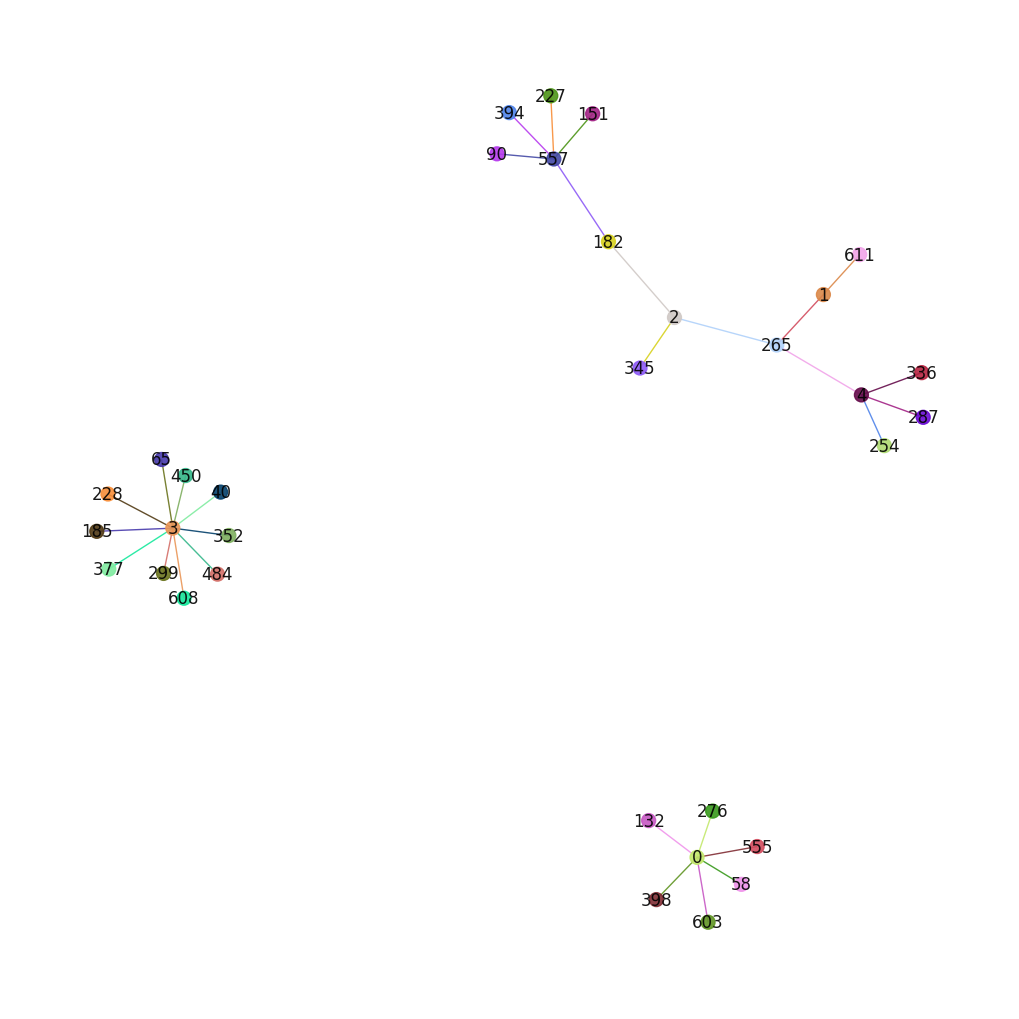

In [ ]:
G, node_positions = read_graph_from_csv(30)

# Adding edges to the graph

Here is a function that adds edges to our graph in accordance with a probability value and a number of edges. In order to find all the non-neighbors for each node, I use the neighbors() function of the networkx library to get all the node's neighbors and then remove this set from the whole set of nodes of the graph. In order to simulate the probability experiment of adding an edge between two nodes, I get a random value from 0 to 1 by using the uniform probability distribution and if than number is lesser or equal to the probability of adding the edge, then the edge is added. In the end, we show the graph.


In [ ]:
def add_random_edges_to_graph(G, node_names_list, NUM_RANDOM_EDGES,EDGE_ADDITION_PROBABILITY):
  graph_nodes = G.nodes() 
  print(graph_nodes)

  for node in graph_nodes:
    neighbors = [n for n in G.neighbors(node)] 
    
    # get the non-neighbors

    non_neighbors = []

    for n in graph_nodes:
      if n not in neighbors:
        non_neighbors.append(n)

    non_neighbors.remove(node) # the node itself shouldn't appear as its neighbor

    # add edges with certain probability

    for i in range(NUM_RANDOM_EDGES):
      if len(non_neighbors) == 0: # break if we examined all neighbors
        break

      n = non_neighbors.pop(randrange(len(non_neighbors))) # get a non-neighbor

      rnd = random.uniform(0, 1)

      if rnd <= EDGE_ADDITION_PROBABILITY: # add with probability
        G.add_edge(node, n)

    
  colors = my_random_color_list_generator(G.number_of_nodes()) # need a color for each node
  my_graph_plot_routine(G, colors, colors, fb_links_styles=[], graph_layout='spring', node_positions=[])

  return G  

Trying out adding 2 edges to each node with a probability of 0.1.

[0, 276, 58, 132, 603, 398, 555, 1, 265, 611, 2, 182, 345, 3, 608, 377, 40, 352, 450, 484, 299, 65, 185, 228, 557, 227, 90, 151, 394, 4, 287, 254, 336]


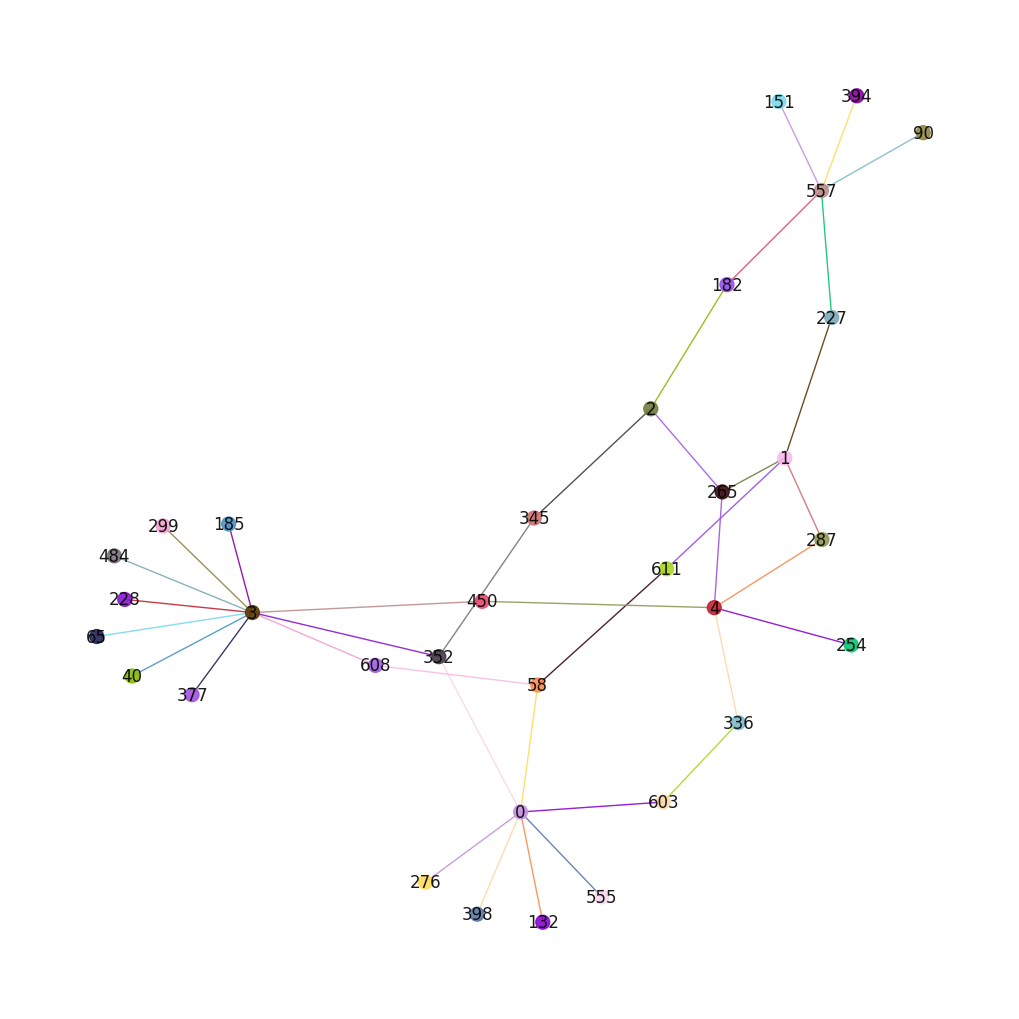

In [ ]:
G = add_random_edges_to_graph(G, node_positions, 2, 0.1)

The following function adds a hamilton cycle to the graph. It does so by iterating over the list of nodes and adding an edge between each pair that we encounter, if the edge doesn't already exist in the graph.

In [ ]:
def add_hamilton_cycle_to_graph(G,node_names_list):
  # add and edge by passing through all the nodes in the order of the list
  
  for i in range(1, len(node_names_list)):
    G.add_edge(node_names_list[i-1], node_names_list[i]) # this adds edge if it doesn't already exist in the Graph

  colors = my_random_color_list_generator(G.number_of_nodes()) # need a color for each node
  my_graph_plot_routine(G, colors, colors, fb_links_styles=[], graph_layout='spring', node_positions=[])

  return G

Trying out adding a hamilton cycle to the graph.

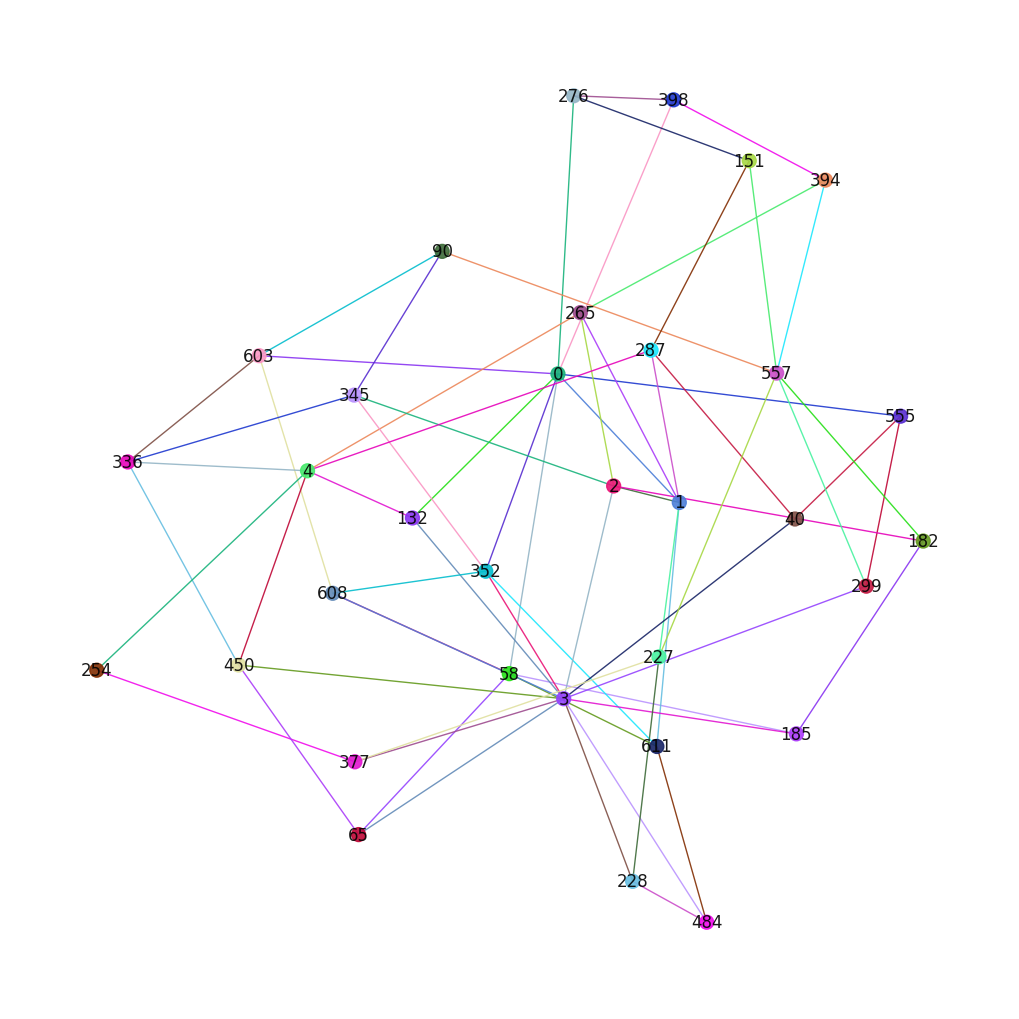

In [ ]:
G = add_hamilton_cycle_to_graph(G, node_positions)

# Girvan-Newman algorithm

In [ ]:
community_tuples = [] # each community is represented by a tuple containing all its nodes

This function takes advantage of the ready-made networkx function for the Girvan-Newman algorithm. It returns K + 1 communities from a graph containing K coherent structures. In order to take the graph corresponding to the K + 1 communities we need take the first element that is returned from the ready-made function.

In [ ]:
def use_nx_girvan_newman_for_communities(G):

    print(bcolors.ENDC + "\tCalling routine " + bcolors.HEADER + "use_nx_girvan_newman_for_communities(G,graph_layout,node_positions)" + bcolors.ENDC +"\n")

    start_time = time.time()

    comp = [c for c in girvan_newman(G)]
    comp[0] = [tuple(c) for c in comp[0]]

    end_time = time.time()

    print(bcolors.ENDC  + "\t===================================================")
    print(bcolors.ENDC  + "\tBUILT-IN computation of ONE-SHOT Girvan-Newman clustering for a graph with",G.number_of_nodes(),"nodes and",G.number_of_edges(),"links. "
                        + "Computation time =", end_time - start_time,"\n")

    return comp[0] # this will return K + 1 communitites in a graph with K connected subgraphs


Trying out the ready Girvan-Newman function and printing out the communities.

In [ ]:
community_tuples = use_nx_girvan_newman_for_communities(G)

	Calling routine use_nx_girvan_newman_for_communities(G,graph_layout,node_positions)

	BUILT-IN computation of ONE-SHOT Girvan-Newman clustering for a graph with 33 nodes and 68 links. Computation time = 0.1419997215270996 



In [ ]:
for community in community_tuples:
  print(community) # printing the nodes of each community

(0, 1, 2, 3, 132, 4, 265, 394, 398, 276, 151, 287, 40, 555, 299, 557, 182, 185, 58, 65, 450, 336, 345, 90, 603, 352, 608, 611, 227, 484, 228)
(377, 254)


# Divisive community detection

In [ ]:
def divisive_community_detection(G,number_of_divisions,graph_layout,node_positions):

    print(bcolors.ENDC + "\tCalling routine " + bcolors.HEADER + "divisive_community_detection(G,number_of_divisions,graph_layout,node_positions)" + bcolors.ENDC +"\n")

    start_time = time.time()

    CUR_PARTITION = [tuple(c) for c in nx.connected_components(G)]
    INITIAL_PARTITION = copy.deepcopy(CUR_PARTITION)
    LIST_OF_DIVISIONS = [] # lists that keep track of each loop's division
    PARTITION_HIERARCHY = []
    PARTITION_HIERARCHY.append([G.subgraph(community) for community in CUR_PARTITION])
  
    while len(CUR_PARTITION) < number_of_divisions:
      LC = [] # list of nodes of GCC

      # Get biggest component

      components_sizes = [len(c) for c in CUR_PARTITION]
      LC = CUR_PARTITION[components_sizes.index(max(components_sizes))]
      LC_graph = G.subgraph(LC)

      # Divide biggest component

      communities = use_nx_girvan_newman_for_communities(LC_graph)
      LC1 = communities[0]
      LC2 = communities[1]
    
      # Update partition

      CUR_PARTITION.remove(LC)
      CUR_PARTITION.append(LC1)
      CUR_PARTITION.append(LC2)
  
      # Update history 

      LIST_OF_DIVISIONS.append([LC, LC1, LC2])
      PARTITION_HIERARCHY.append([G.subgraph(community) for community in CUR_PARTITION])

    end_time = time.time()

    print(bcolors.ENDC  + "\t===================================================")
    print(bcolors.ENDC  + "\tComputation of HIERARCHICAL BIPARTITION of G in communities, "
                        + "using the BUILT-IN girvan-newman algorithm, for a graph with",G.number_of_nodes(),"nodes and",G.number_of_edges(),"links. "
                        + "Computation time =", end_time - start_time,"\n")

    return PARTITION_HIERARCHY, LIST_OF_DIVISIONS
    

In [ ]:
hierarchy, list_of_divisions = divisive_community_detection(G, 10, 'spring', node_positions)

	Calling routine divisive_community_detection(G,number_of_divisions,graph_layout,node_positions)

	Calling routine use_nx_girvan_newman_for_communities(G,graph_layout,node_positions)

	BUILT-IN computation of ONE-SHOT Girvan-Newman clustering for a graph with 33 nodes and 68 links. Computation time = 0.13855624198913574 

	Calling routine use_nx_girvan_newman_for_communities(G,graph_layout,node_positions)

	BUILT-IN computation of ONE-SHOT Girvan-Newman clustering for a graph with 31 nodes and 64 links. Computation time = 0.12061429023742676 

	Calling routine use_nx_girvan_newman_for_communities(G,graph_layout,node_positions)

	BUILT-IN computation of ONE-SHOT Girvan-Newman clustering for a graph with 28 nodes and 57 links. Computation time = 0.07929515838623047 

	Calling routine use_nx_girvan_newman_for_communities(G,graph_layout,node_positions)

	BUILT-IN computation of ONE-SHOT Girvan-Newman clustering for a graph with 15 nodes and 27 links. Computation time = 0.01655721664428711 

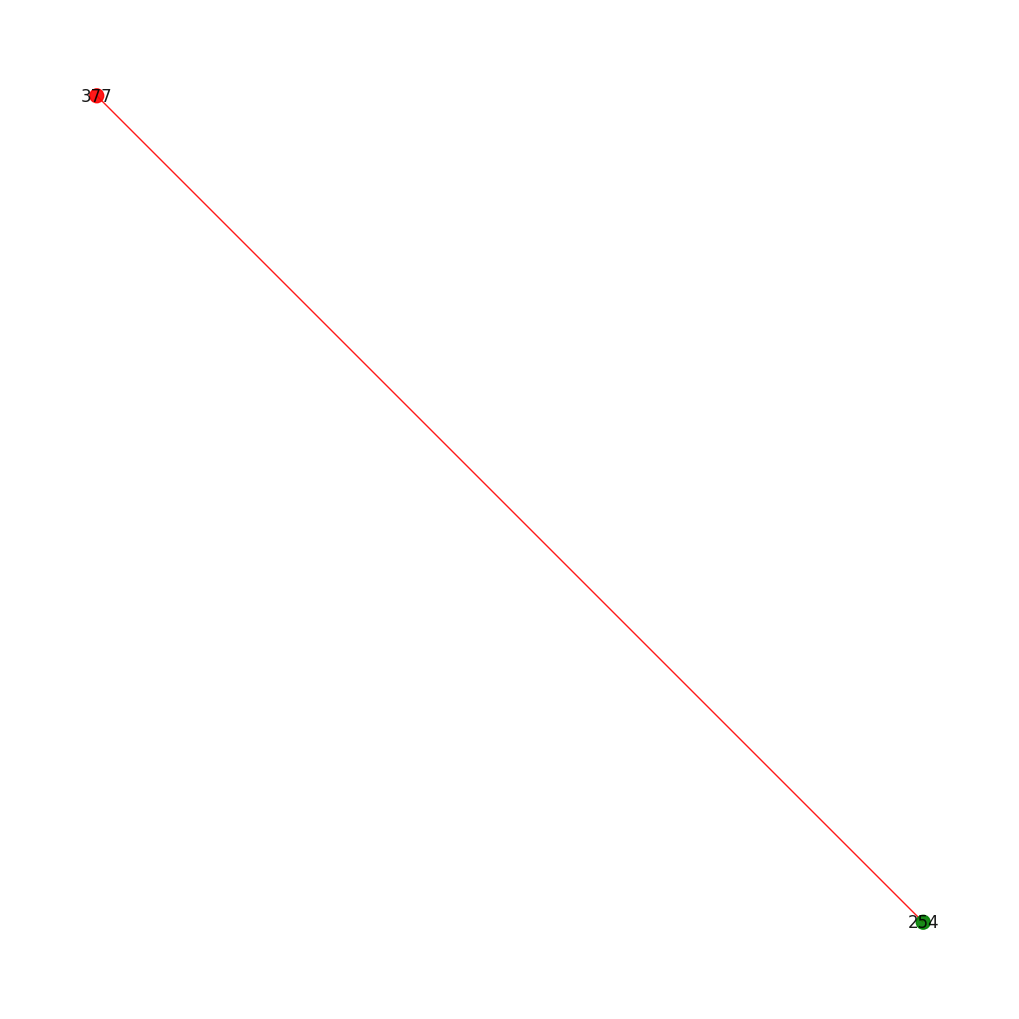

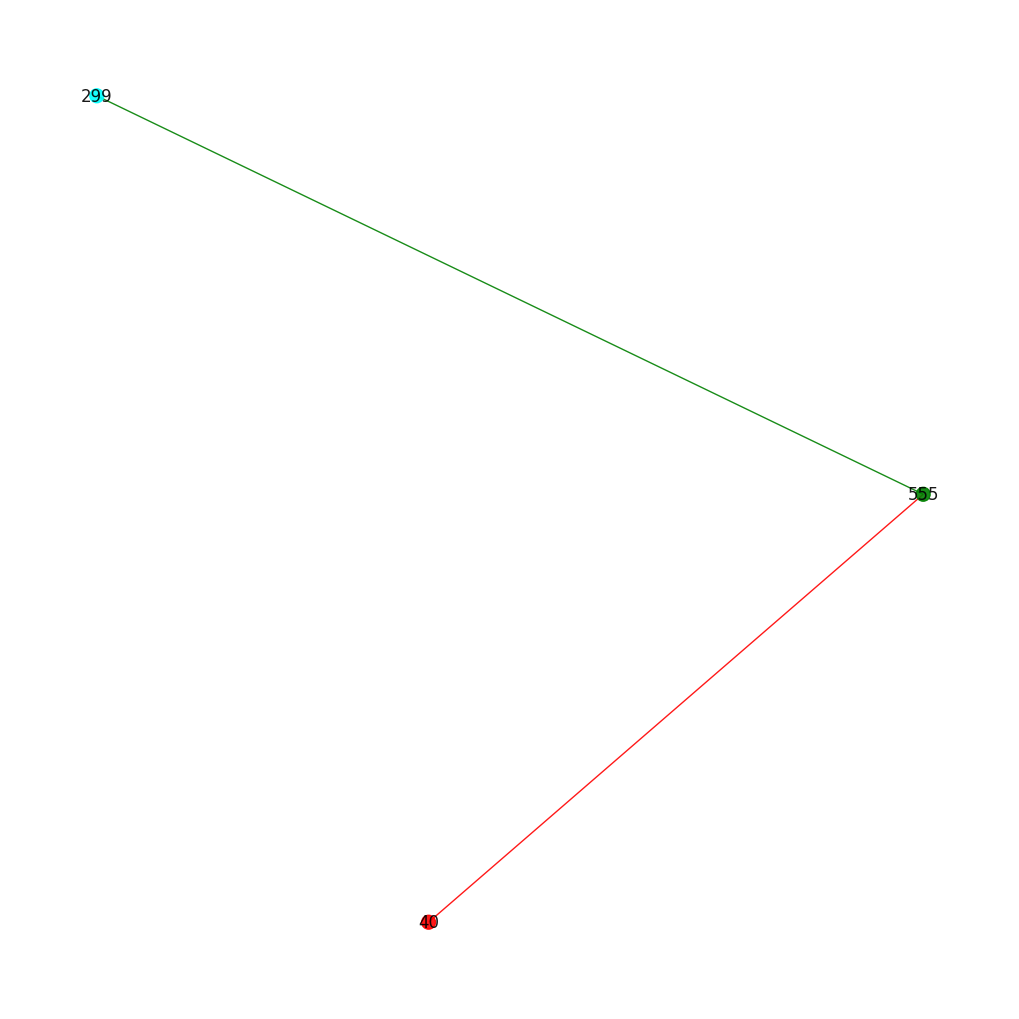

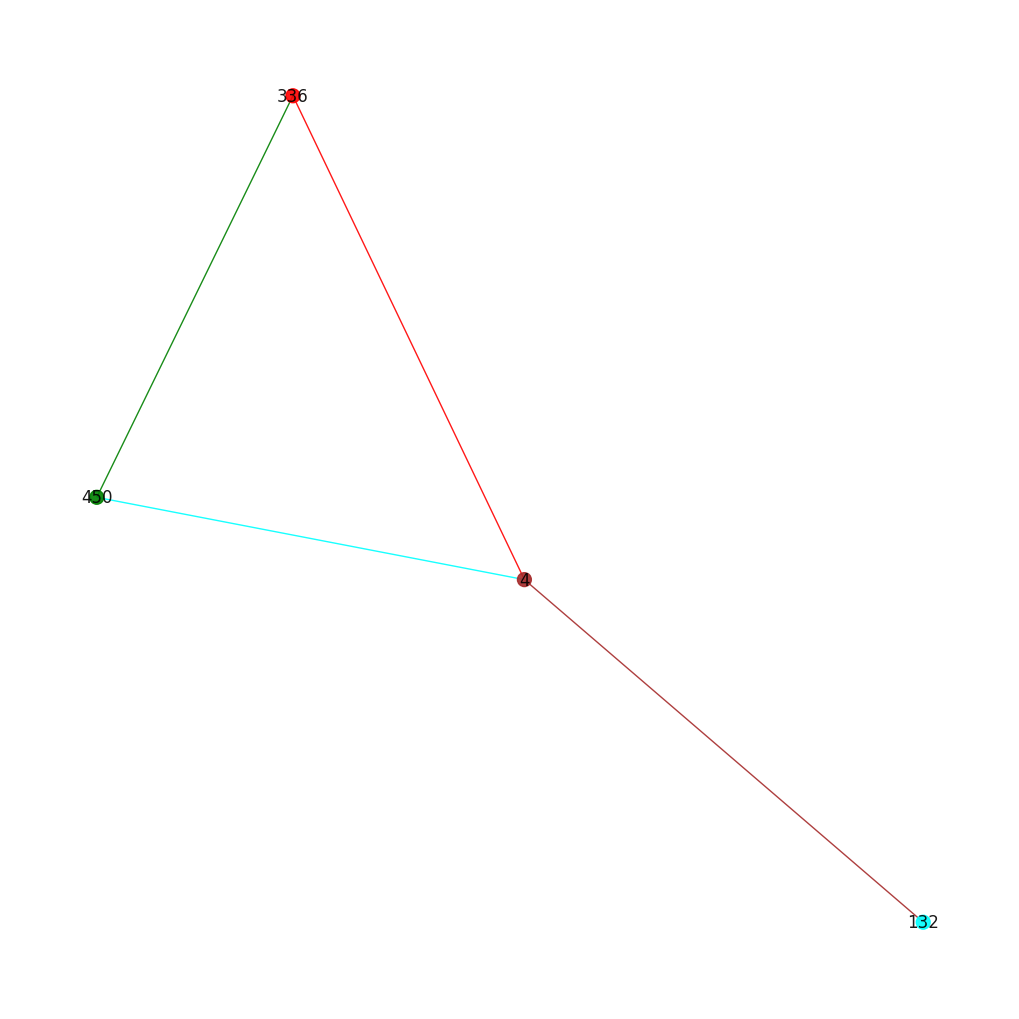

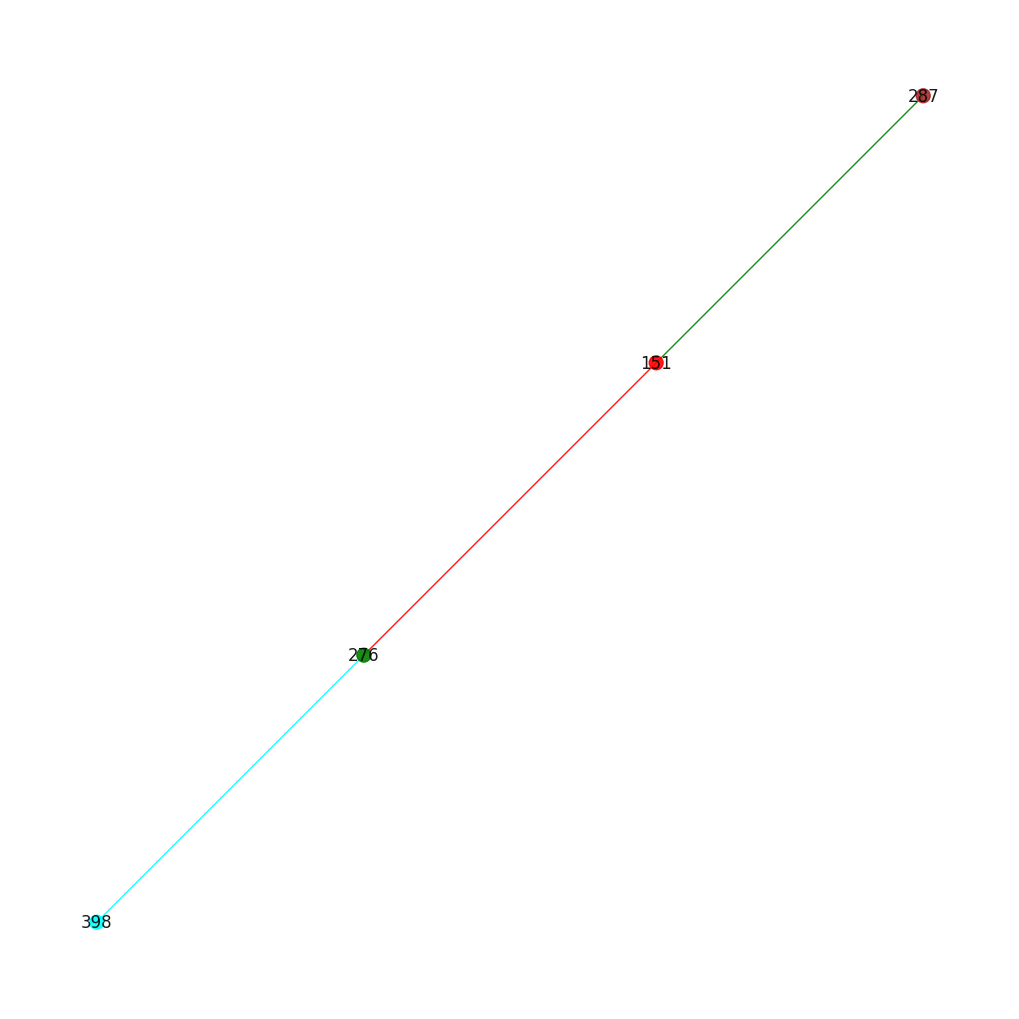

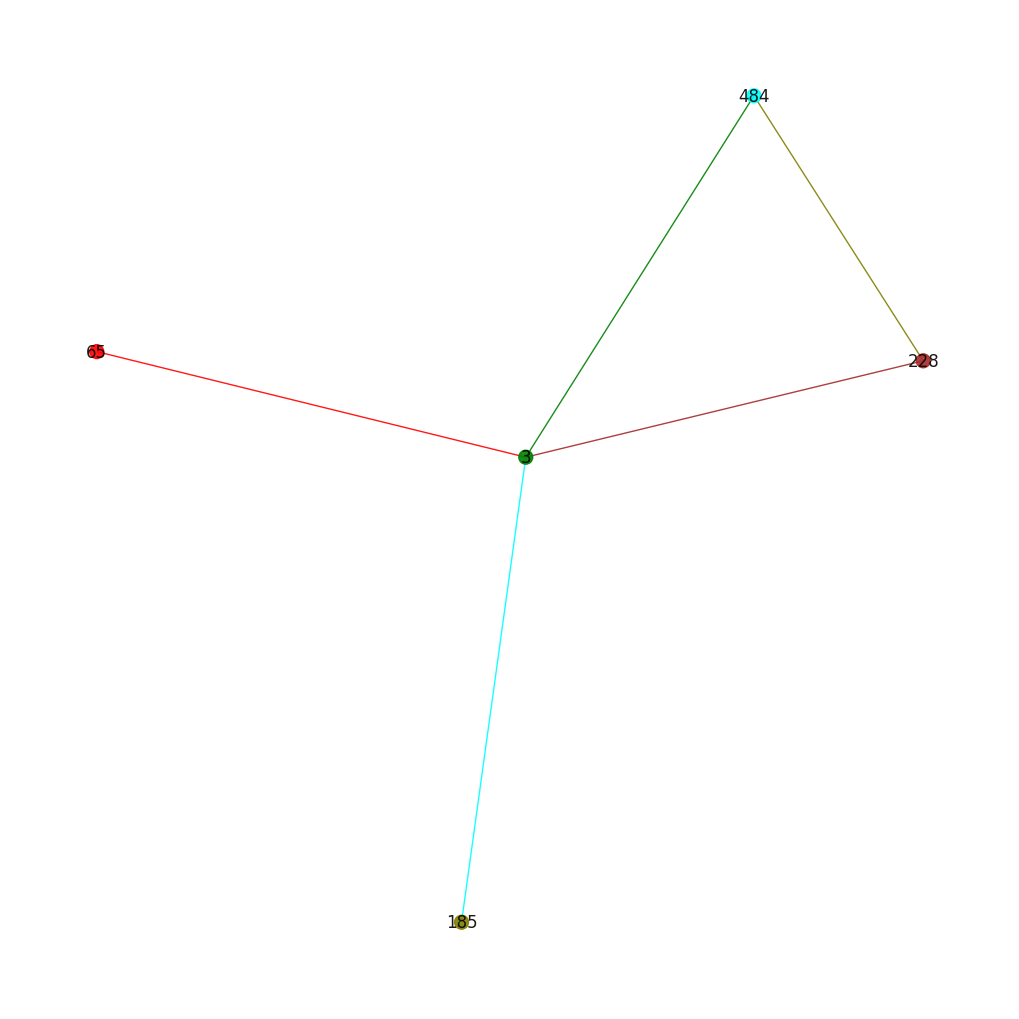

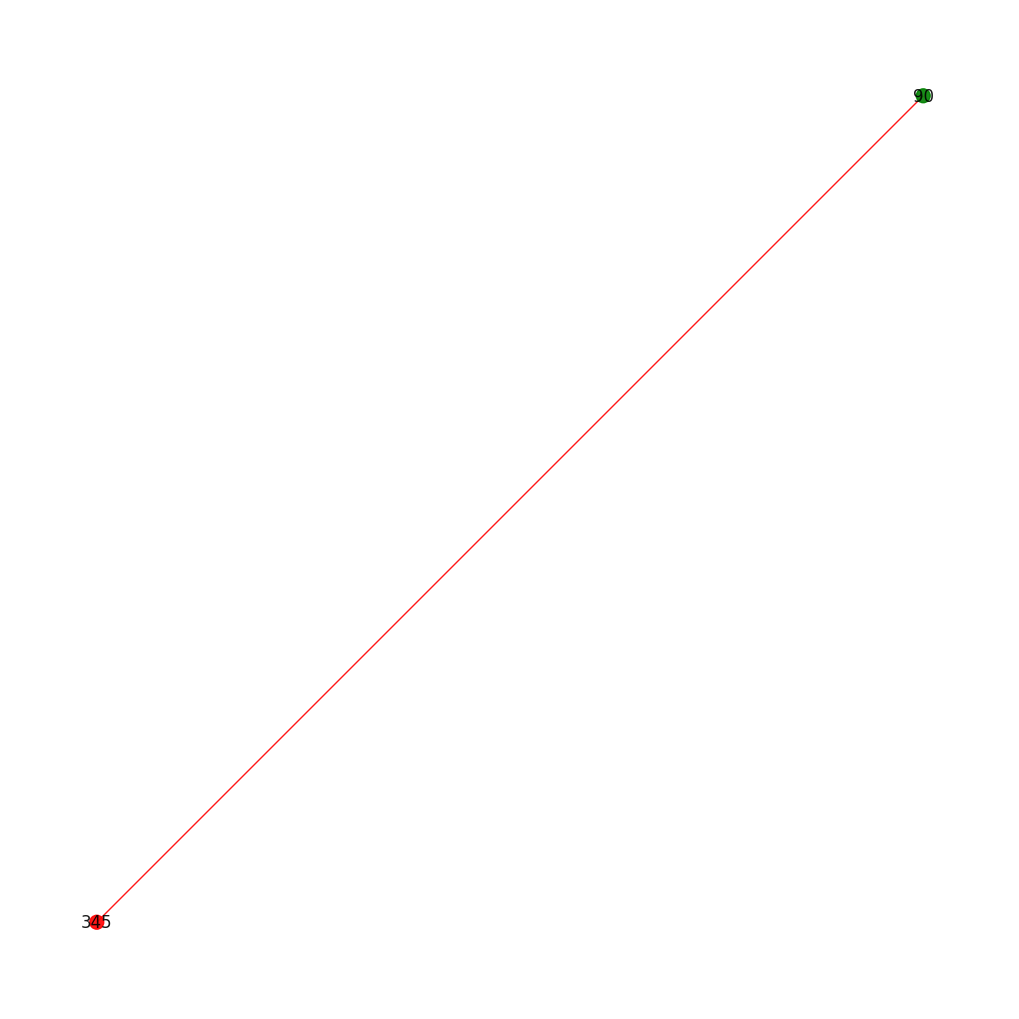

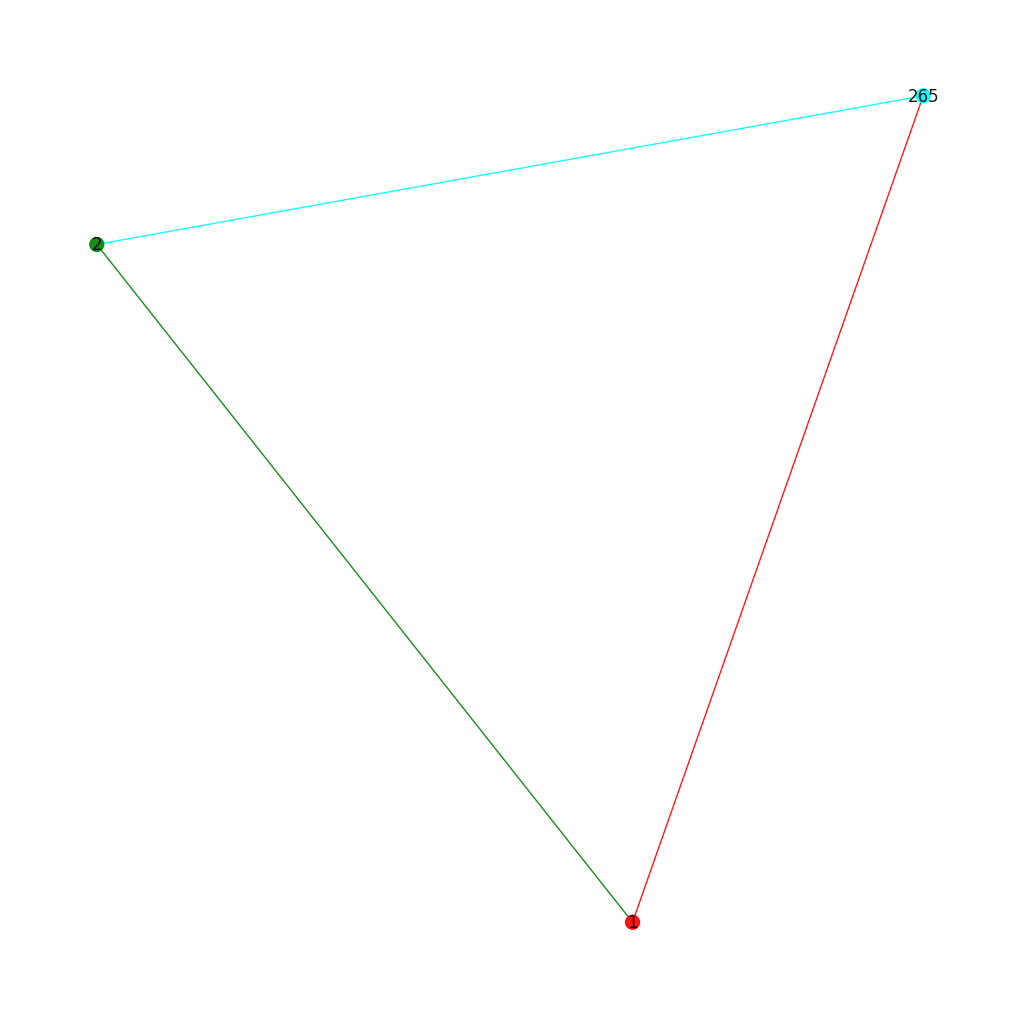

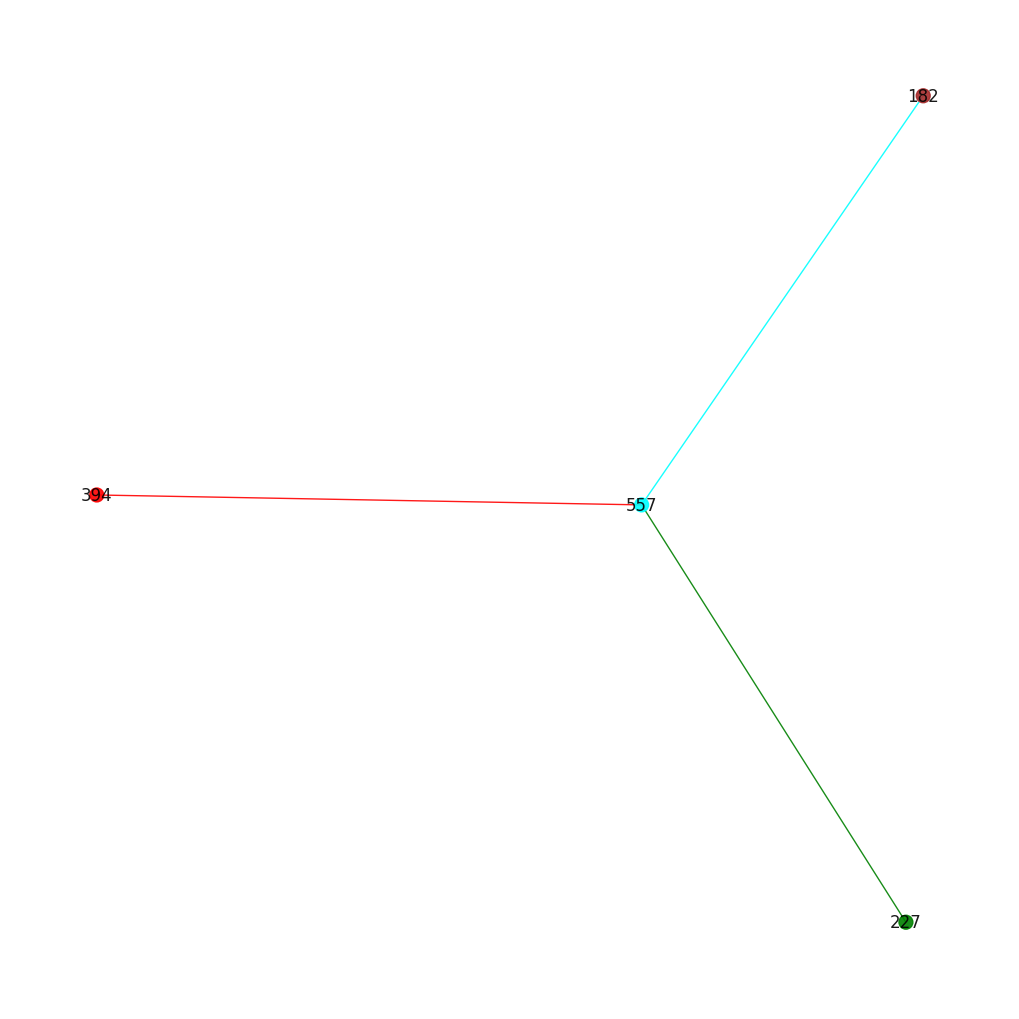

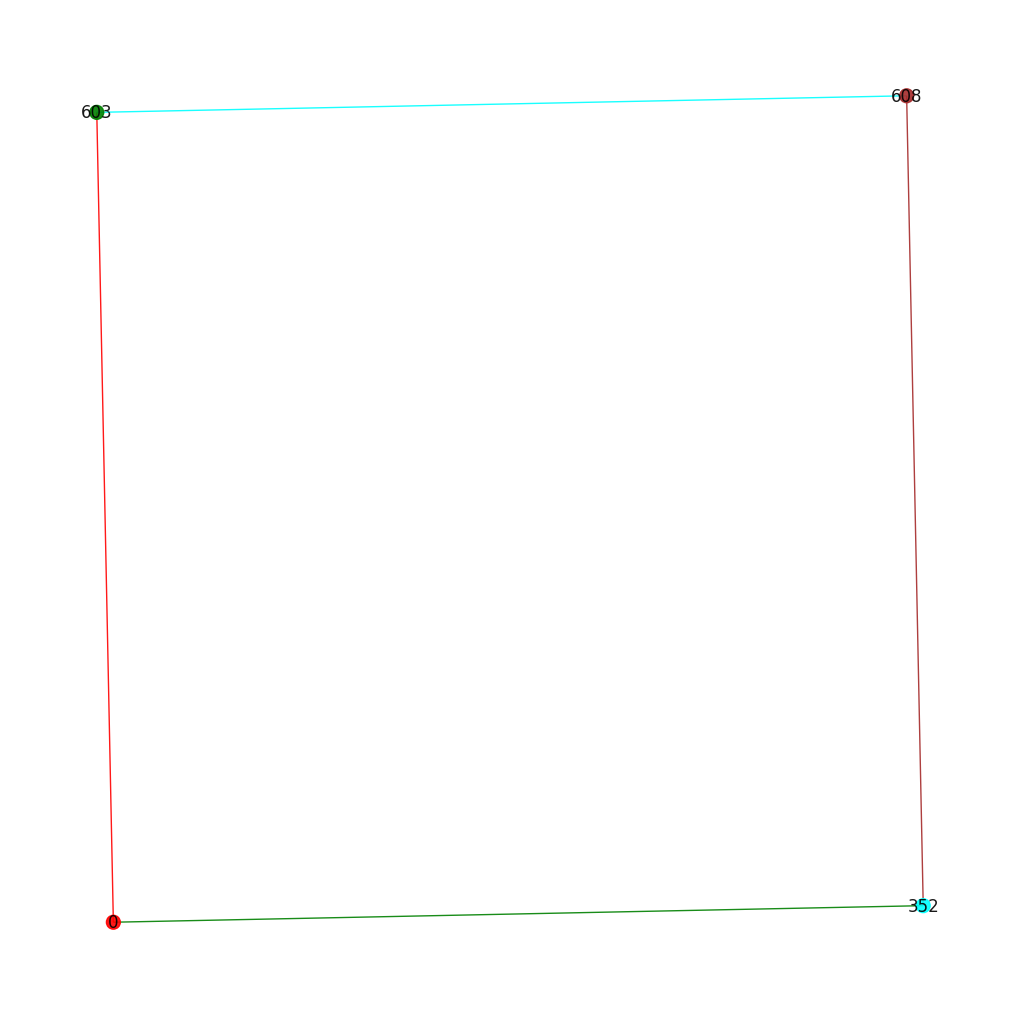

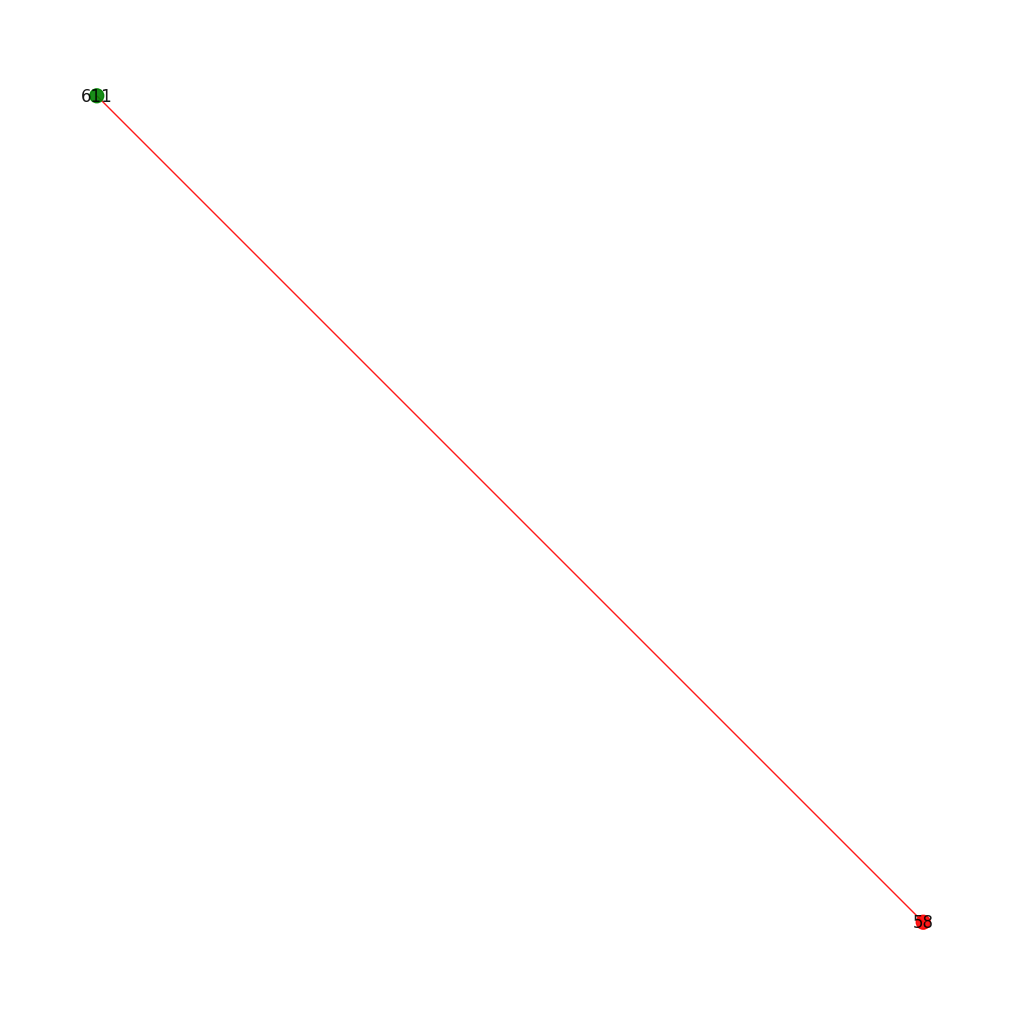

In [ ]:
for graph in hierarchy[-1]: # print all the partitions that occured from the division, they will be last in the hierarchy of divisions
  colors = my_random_color_list_generator(graph.number_of_nodes()) # need a color for each node
  my_graph_plot_routine(graph, colors, colors, fb_links_styles=[], graph_layout='spring', node_positions=[])

# Community visualisation

Here is a graph-component visualisation method. I join all the components in the same plot. In order to use a different color for each community, each time we exam a new community I add to the color map a certain color as many times as the number of nodes in the corresponding community. In that way, the change of color will occur once the draw() function starts plotting the nodes of the next community each time.



In [ ]:
def visualize_communities(G,community_tuples,graph_layout,node_positions):

    print(bcolors.ENDC      + "\tCalling routine " 
                            + bcolors.HEADER + "visualize_communities(G,community_tuples,graph_layout,node_positions)" + bcolors.ENDC +"\n")


    colors = my_random_color_list_generator(len(community_tuples)) # need a color for each node

    joined_graph = nx.Graph() # merge all graphs into one

    color_map = []

    for i in range(len(community_tuples)):
        for node_counter in range(G.subgraph(community_tuples[i]).number_of_nodes()): # use same color for all nodes of subgraph
          color_map.append(colors[i])
        if i == 0:
          joined_graph = G.subgraph(community_tuples[i])
        else:
          joined_graph = nx.compose(joined_graph, G.subgraph(community_tuples[i]))

    plt.figure(figsize=(10,10))
    nx.draw(joined_graph, node_color=color_map, with_labels=True)
    plt.show()

Time to visualise all the communities that occured from the division in the above section, in one joint graph.

In [ ]:
new_community_tuples = [tuple(hierarchy[-1][i].nodes()) for i in range(len(hierarchy[-1]))]

	Calling routine visualize_communities(G,community_tuples,graph_layout,node_positions)



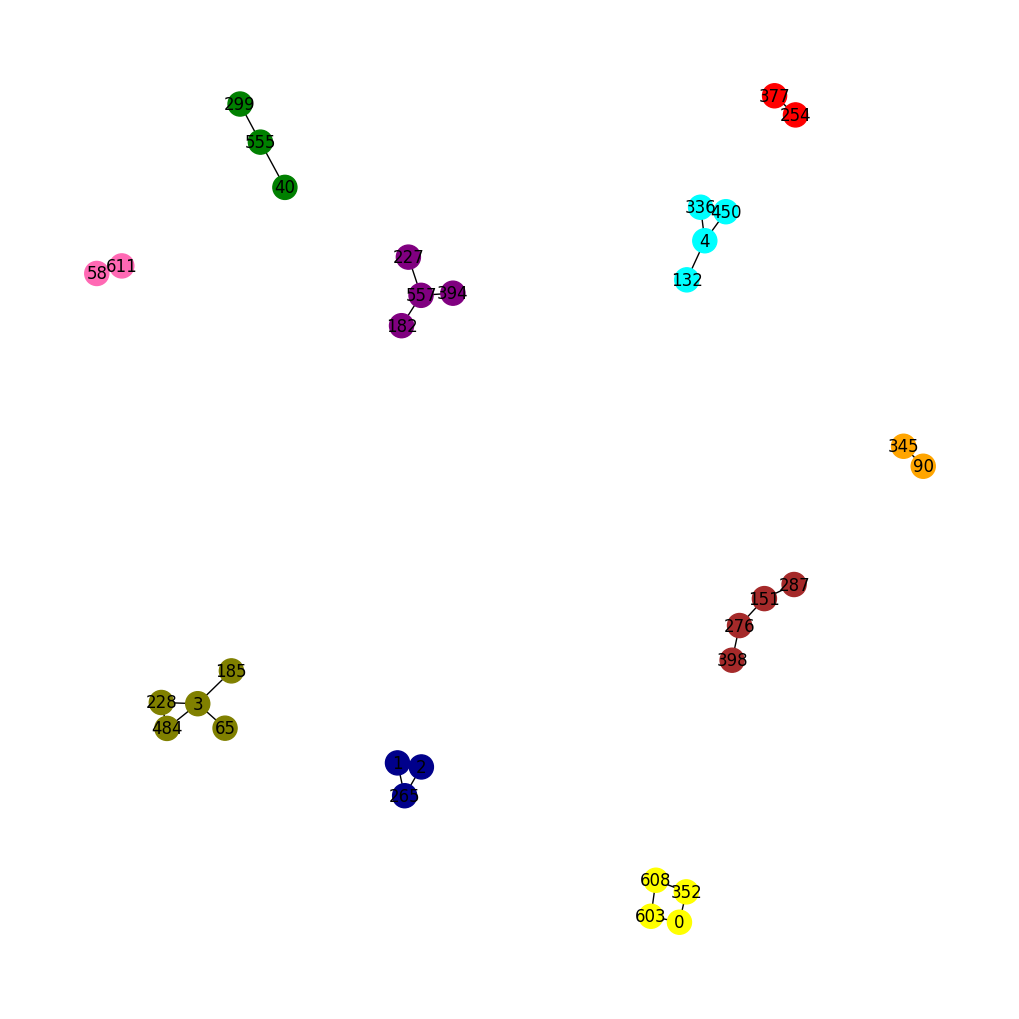

In [ ]:
visualize_communities(G, new_community_tuples, 'spring', node_positions)

# Optimal partition based on modularity

This is the function that determines which is the best partition, depending on the modularity score of each. The modularity scores are computed using the ready-made networkx library. For each partition, I create an nx.Graph with all its components and then pass the joined graph as a parameter to the modularity function. I save the returned score for each partition and then create a bar diagram of all the scores and return the best partition, which I also show.

In [ ]:
def determine_opt_community_structure(G,hierarchy_of_community_tuples):
    print(bcolors.ENDC + "\tCalling routine " + bcolors.HEADER + "determine_opt_community_structure(G,hierarchy_of_community_tuples)" + bcolors.ENDC +"\n")

    modularity_list = []

    for partition in hierarchy_of_community_tuples:
        joined_graph = nx.Graph() # merge all graphs into one

        for i in range(len(partition)):
            if i == 0:
                joined_graph = partition[i]
            else:
                joined_graph = nx.compose(joined_graph, partition[i])

        modularity = nx_comm.modularity(joined_graph, partition)
        modularity_list.append(modularity)

    print(modularity_list)
    plt.figure(figsize=(12,9))
    partitions_size = [len(partition) for partition in hierarchy_of_community_tuples]
    plt.bar(partitions_size, modularity_list, align='center', alpha=0.7)
    plt.xticks(partitions_size, partitions_size)
    plt.xlabel('NUMBER OF COMMUNITIES IN PARTITION')
    plt.ylabel('MODULARITY VALUE OF PARTITION')

    plt.show()

    optimal_partition = hierarchy_of_community_tuples[modularity_list.index(max(modularity_list))]
    visualize_communities(G, optimal_partition, 'spring', node_positions)

    return optimal_partition   

Let's try out this function on the hierarchy of partitions that occured from the divisive community detection.

	Calling routine determine_opt_community_structure(G,hierarchy_of_community_tuples)

[0.0, 0.030295857988165746, 0.0961111111111111, 0.5407986111111112, 0.638182801514332, 0.68875, 0.7853061224489796, 0.8154269972451792, 0.8466666666666666, 0.8751714677640603]


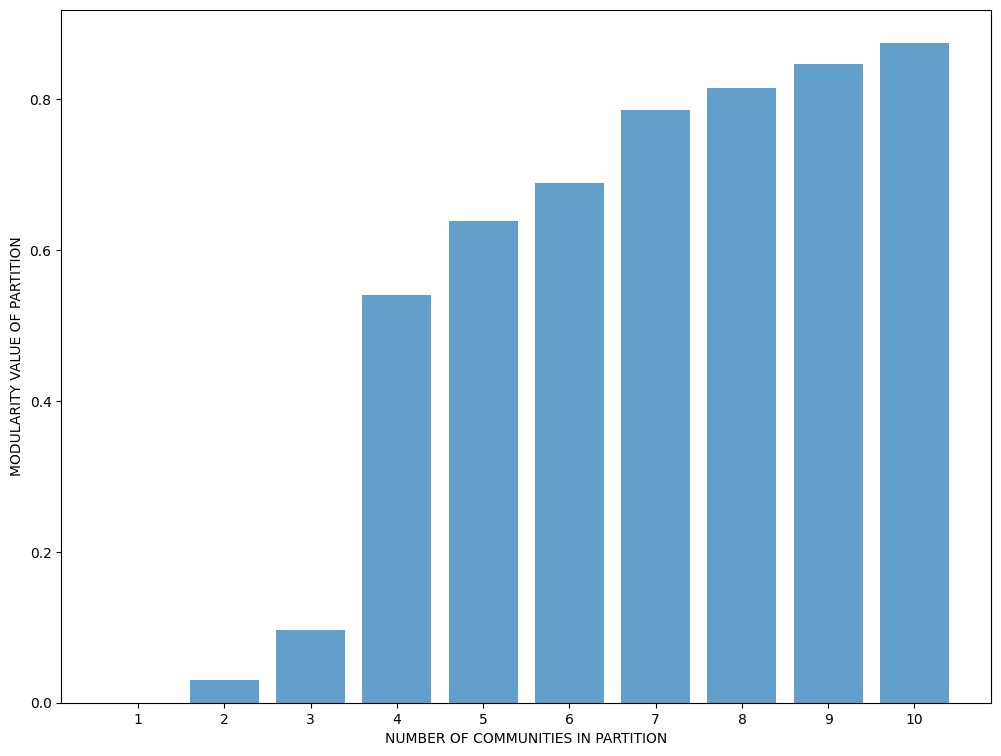

	Calling routine visualize_communities(G,community_tuples,graph_layout,node_positions)



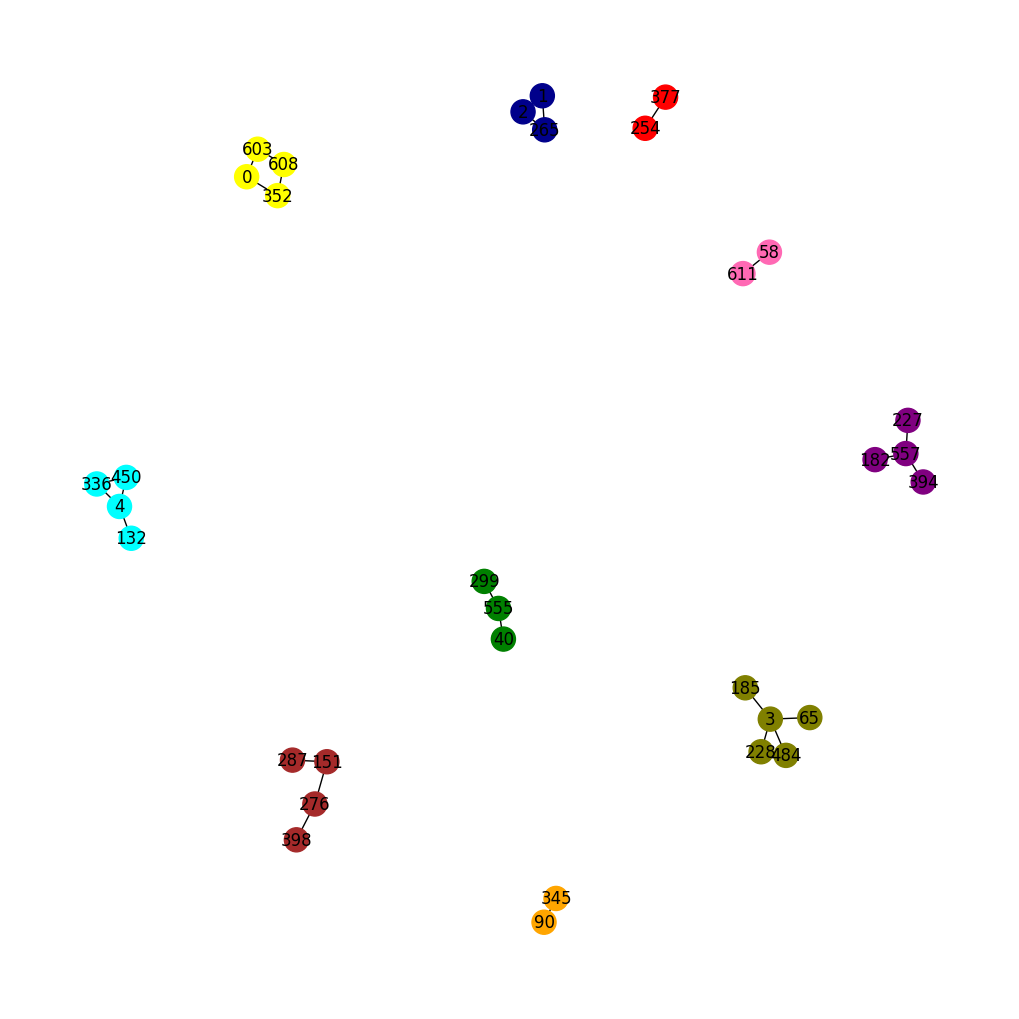

In [ ]:
optimal_partition = determine_opt_community_structure(G, hierarchy)